<a href="https://colab.research.google.com/github/Anmol42/IDP-sem4/blob/generator_encode/notebooks/GAN_colorize_with_validation_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataloader import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/Datasets/img_align_celeba.zip
 ## Silenced the unzip action

In [4]:
from skimage.io import imread_collection
path = "/content/img_align_celeba/10*jpg"
train_ds = imread_collection(path)

In [5]:
from skimage.color import rgb2lab,lab2rgb
from skimage.transform import resize
images= torch.zeros(len(train_ds),3,128,128)
for i,im in enumerate(train_ds):
  im = resize(im, (128,128,3),
                       anti_aliasing=True)
  image = rgb2lab(im)
  image = torch.Tensor(image)
  image = image.permute(2,0,1)
  #print(i)
  images[i]=image
print(images.max(),images.min())
images[:,0] = images[:,0]/100
images[:,1:] = images[:,1:]/128
print(images.max(),images.min())
batch_size = 100

tensor(99.6549) tensor(-107.4650)
tensor(0.9965) tensor(-0.8396)


In [7]:
class encoder(nn.Module):
    def __init__(self):         # z is input noise
        super(encoder,self).__init__()
        self.upsample = nn.Sequential(nn.Conv2d(1,32,kernel_size=1),
                                      nn.ReLU())
        self.conv1 = nn.Sequential(nn.Conv2d(32,64,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(64),
        nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(64,128,kernel_size=5,padding=2,stride=2),
                                   nn.BatchNorm2d(128),
        nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(128,256,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(256),
        nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(256,512,kernel_size=5,padding=2,stride=2),    #size is 8x8 at this point
        nn.BatchNorm2d(512),
        nn.ReLU())
        # BottleNeck
        self.bottleneck = nn.Sequential(nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.LeakyReLU())     # size 4x4
    def forward(self,x):
        out1 = self.upsample(x)
        out1 = self.conv1(out1)
        #print("out1 ",out1.shape)
        out2 = self.conv2(out1)
        #print("out 2",out2.shape)
        out3 = self.conv3(out2)
        #print("out3 ",out3.shape)
        out4 = self.conv4(out3)
        #print("after conv4",out4.shape)
        out5 = self.bottleneck(out4)
        #print("after bottleneck",out5.shape)  # 4096*2 sized vector is returned
        return out5

In [8]:
## generator model
class generator(nn.Module):
    def __init__(self,encoder_mu,encoder_sig):         # z is input noise
        super(generator,self).__init__()    #noise handling is handled by encoder nets
        self.encoder_mu=encoder_mu
        self.encoder_sig=encoder_sig
        self.deconv7 = nn.Sequential(nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())
        self.deconv6 = nn.Sequential(nn.ConvTranspose2d(256,128,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())
        self.deconv5 = nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(64,32,kernel_size=5,stride=1,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU())
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU())
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU())
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(8,2,kernel_size=4,stride=2,padding=1),
        nn.Tanh())

    def forward(self,xb,z):
        mu = self.encoder_mu(xb)    #512x4x4 sized tensor
        sig = torch.abs(self.encoder_sig(xb))
        noise = z*sig + mu
        out = self.deconv7(noise)
        out = self.deconv6(out)
        out = self.deconv5(out)
        out = self.deconv4(out)
        out = self.deconv3(out)
        out = self.deconv2(out)
        out = self.deconv1(out)
        return torch.cat((xb,out),axis=1)
        

In [9]:
## discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,8,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8,16,kernel_size=5,stride=2,padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32,32,kernel_size=5,padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.Flatten()
        )
    def forward(self,x):
        out = self.network(x)
        out = torch.sigmoid(out)
        return out

In [10]:
dis_model = discriminator()
encoder_mu = encoder()
encoder_sig = encoder()
gen_model = generator(encoder_mu=encoder_mu,encoder_sig=encoder_sig)

In [27]:
print(gen_model(images[:10,0].unsqueeze(1).cuda(0),torch.zeros((10,512,4,4,)).cuda(0)).shape)

torch.Size([10, 3, 128, 128])


In [34]:
train_dl = DataLoader(images[:1000],batch_size,shuffle=True,pin_memory=True,num_workers=2)
val_dl = DataLoader(images[8000:9000],batch_size, num_workers=2,pin_memory=True)
test_dl = DataLoader(images[9000:],batch_size,num_workers=2)

In [35]:
bceloss = nn.BCEWithLogitsLoss()
#minimise this # t is whether the image is fake or real; x is prob vect of patches being real/fake.
def loss_inf(x,t):    # probability vector from discriminator as input
    return int(t)*(bceloss(x,torch.ones_like(x))) + (1-int(t))*bceloss(x,torch.zeros_like(x))

In [36]:
cosloss = nn.L1Loss()
def gen_loss(x,y):
    return cosloss(x,y)

In [37]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')
test_dl = DeviceDataLoader(test_dl,'cuda')
gen_model.to('cuda')
dis_model.to('cuda')

discriminator(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): LeakyReLU(negative_slope=0.1)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): LeakyReLU(negative_slope=0.1)
    (16): Conv2d(128, 256, kernel_size=(3,

In [39]:
def fit(epochs,lr_g,lr_d,generator,discriminator,batch_size,opt_func=torch.optim.Adam):
    generator.train()
    discriminator.train()
    gen_optimize = opt_func(generator.parameters(),lr_g)
    dis_optimize = opt_func(discriminator.parameters(),lr_d)
    train_g_history,train_d_history = [],[]
    val_g_history, val_d_history = [],[]
    for epoch in range(epochs):
        epoch_loss_g = torch.zeros(1).to('cuda')
        epoch_loss_d = torch.zeros(1).to('cuda')
        noise = torch.randn(batch_size,512,4,4).to('cuda')
        for batch in train_dl:
            out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 

            real_score = discriminator(batch) # how real is the og input image
            fake_score = discriminator(out) # how real is the generated image  
            loss_d = loss_inf(real_score,1) + loss_inf(fake_score,0)# discriminator
            #print(loss_d.item())
            loss_d.backward(retain_graph=True)
            dis_optimize.zero_grad()
            dis_optimize.step()
            
            #out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
            real_score = discriminator(batch) # how real is the og input image
            fake_score = discriminator(out) # how real is the generated image  

            loss_g = 5*gen_loss(out,batch) + loss_inf(fake_score,1)
            #print(loss_g.shape)
            loss_g.backward()
            gen_optimize.step()
            gen_optimize.zero_grad()

            with torch.no_grad():
              epoch_loss_g += loss_g
              epoch_loss_d += loss_d
        train_d_history.append(epoch_loss_d)
        train_g_history.append(epoch_loss_g)
        epoch_loss_g = 0
        epoch_loss_d = 0
        for batch in val_dl:
            with torch.no_grad():
              out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
              real_score = discriminator(batch) # how real is the og input image
              fake_score = discriminator(out) # how real is the generated image  
              loss_d = loss_inf(real_score,1) + loss_inf(fake_score,0)# discriminator
              loss_g = 5*gen_loss(out,batch) + loss_inf(fake_score,1)
              epoch_loss_g += loss_g
              epoch_loss_d += loss_d

        
        val_g_history.append(epoch_loss_g.item())
        val_d_history.append(epoch_loss_d.item())
        if epoch % 10 == 0:
            print("Gen Epoch Loss",epoch_loss_g)
            print("Discriminator Epoch loss",epoch_loss_d)
    return train_d_history,train_g_history,val_d_history,val_g_history


In [ ]:
loss_h = fit(50,0.0002,0.0002,gen_model,dis_model,batch_size,opt_func=torch.optim.Adam)

Gen Epoch Loss tensor(8.2700, device='cuda:0')
Discriminator Epoch loss tensor(14.4803, device='cuda:0')


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_h[3])

In [ ]:
from skimage.color import rgb2lab,lab2rgb,rgb2gray
def tensor_to_pic(tensor : torch.Tensor) -> np.ndarray:
    tensor[0] *=  100
    tensor[1:]*=  128
    image = tensor.permute(1,2,0).detach().cpu().numpy()
    image = lab2rgb(image)
    return image

def show_images(n,dataset = images,gen=gen_model,dis=dis_model) -> None:
  gen_model.eval()
  dis_model.eval()
  z = torch.randn(1,256).to('cuda')
  #z = torch.ones_like(z)
  image_tensor = dataset[n].to('cuda')
  gen_tensor = gen(image_tensor[0].unsqueeze(0).unsqueeze(0),z)[0]
  image = tensor_to_pic(image_tensor)
  tp = np.zeros_like(image)
  gray_scale = rgb2gray(image)
  tp[:,:,0] = tp[:,:,1] = tp[:,:,2] = gray_scale 
  print(gray_scale.shape)
  #print(torch.sum(gen_tensor))
  gen_image = tensor_to_pic(gen_tensor)
  to_be_shown = np.concatenate((gen_image,tp,image),axis=1)
  plt.figure(figsize=(20,20))
  plt.imshow(to_be_shown)
  plt.show()
  


(128, 128)


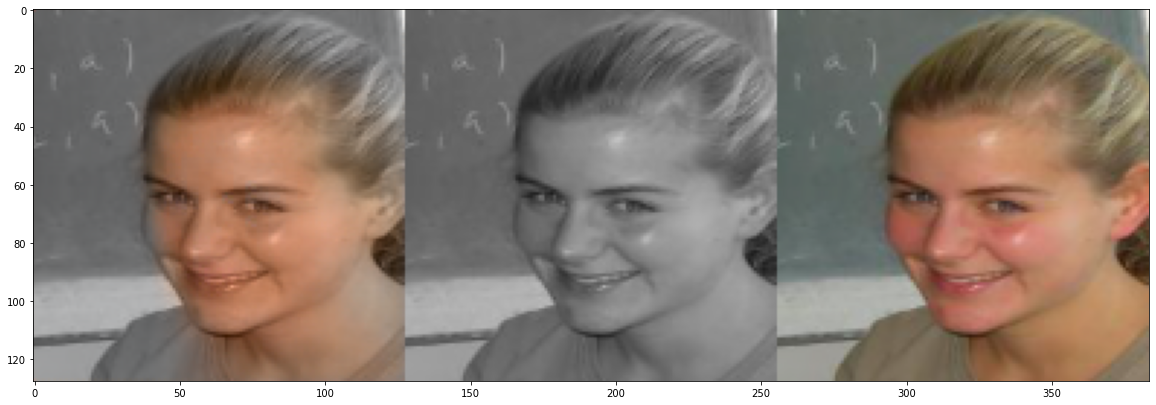

In [ ]:
show_images(845)      ## Shows generated and coloured images side by side